# # Model: Decision Trees

### Author: Ehsan Gharib-Nezhad

### Terminology
Decision trees look like upside down trees. 
- What we see on top is known as the "root node," through which all of our observations are passed.
- At each internal split, our dataset is partitioned.
- A "parent" node is split into two or more "child" nodes.
- At each of the "leaf nodes" (colored orange), we contain a subset of records that are as pure as possible.

The **Gini impurity** is the probability a randomly chosen class will be mislabeled if it was randomly labeled.

Suppose $p_i$ is the probability that class $i$ would be chosen uniformly at random. Then:

$$
\begin{eqnarray*}
\text{Gini impurity} &=& \sum_{i=1}^{classes} p_i(1 - p_i) \\
                     &=& 1 - \sum_{i=1}^{classes} p_i^2. \\
\text{Gini impurity (2 classes)} &=& 1 - p_1^2 - p_2^2. \\
\text{Gini impurity (3 classes)} &=& 1 - p_1^2 - p_2^2 - p_3^2. \\
\end{eqnarray*}
$$

In [1]:
from myfunctions import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler


In [41]:
df = pd.read_csv('../datasets/text_processed_all_posts_combined_imbalanced.csv',index_col=0)
is_balanced = False # set True is the dataset is balanced!!! 

### Set up X and Y

In [42]:
X = df['token']
y = df['is_Covid19positive']

## check baseline:

In [43]:
y.value_counts(normalize = True)

1    0.929286
0    0.070714
Name: is_Covid19positive, dtype: float64

## train test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    random_state = 42)

In [45]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.929273
 0    0.070727
 Name: is_Covid19positive, dtype: float64,
 1    0.929322
 0    0.070678
 Name: is_Covid19positive, dtype: float64)

# ======================================================

## Use count vectorizer

In [46]:
cvec = CountVectorizer()

In [47]:
Xcv_train = cvec.fit_transform(X_train)
Xcv_test  = cvec.transform(X_test)

# ======================================================


## For imbalanced case

In [48]:
ros = RandomOverSampler()

Xcv_train , y_train = ros.fit_resample(Xcv_train, y_train)

# ================================================

# Decision Tree

In [49]:
# Instantiate model with random_state = 42.
dt = DecisionTreeClassifier(random_state= 42)

## Note: The role of randomness

The algorithms that fit tree-based methods involve randomness, which means it's important to specify a `random_state` if you want to reproduce your results. This is always a good idea.
- Changing `random_state` from 42 to 43 reduces our model's test performance by 6%!

In [50]:
dt.fit(Xcv_train, y_train)

DecisionTreeClassifier(random_state=42)

## Evaluate Model

Score on training set: 0.9985480235783634
Score on testing set: 0.9523982119125287
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       585
           1       0.97      0.98      0.97      7692

    accuracy                           0.95      8277
   macro avg       0.82      0.81      0.82      8277
weighted avg       0.95      0.95      0.95      8277



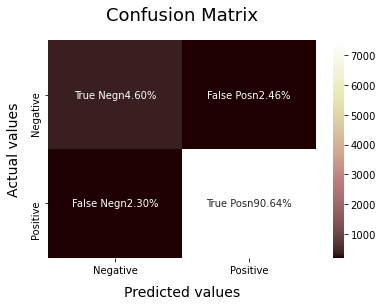

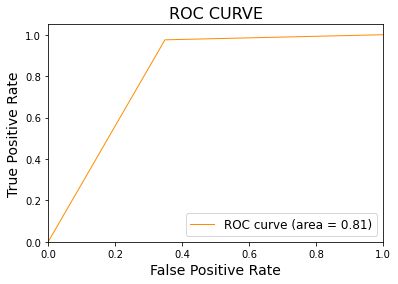

In [51]:
# View confusion matrix
model_Evaluate(dt, Xcv_train, Xcv_test, y_train, y_test)

In [28]:
save_model_Evaluate_values(dt, Xcv_train, Xcv_test, y_train, y_test,  
                             model_name='Decision Tree', balanced=is_balanced)

(   score   metric          model balanced
 0   1.00  R_train  Decision Tree      yes
 1   0.85   R_test  Decision Tree      yes,
    is_pandemicPreps  is_covid19positive     metric          model balanced
 0              0.84                0.86  precision  Decision Tree      yes
 1              0.82                0.88     recall  Decision Tree      yes
 2              0.83                0.87     fscore  Decision Tree      yes
 3            586.00              740.00    support  Decision Tree      yes,
    score     metric          model balanced
 0   0.36   True Neg  Decision Tree      yes
 1   0.08  False Pos  Decision Tree      yes
 2   0.07  False Neg  Decision Tree      yes
 3   0.49   True Pos  Decision Tree      yes)

# Feature Importance

In [29]:
#create a dataframe for our X_train_cv to use later:

df_X_train = pd.DataFrame(Xcv_train.todense(), columns=cvec.get_feature_names())

In [30]:
f = {'Feature Name':df_X_train.columns,'Feature Coefficient':dt.feature_importances_}
fi = pd.DataFrame(f)

fi.sort_values(by=['Feature Coefficient'], ascending = False).head(20)

,Feature Name,Feature Coefficient
9582,symptom,0.343804
9759,test,0.100828
3583,fever,0.045723
7559,prep,0.045117
5900,mask,0.023200
9859,throat,0.017769
5760,lung,0.013645
2241,covid,0.012220
1222,breath,0.007655
10488,use,0.007289


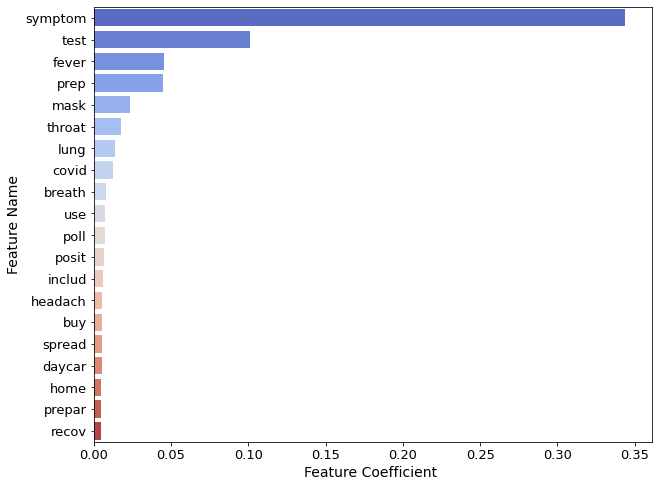

In [31]:
plt.figure( figsize=(10,8))
sns.barplot(x='Feature Coefficient',y='Feature Name', 
            data=fi.sort_values(by='Feature Coefficient', ascending=False).iloc[0:20],
            palette='coolwarm')
plt.xlabel('Feature Coefficient ',fontsize=14)
plt.ylabel('Feature Name', fontsize = 14)
plt.tick_params('both', labelsize = 13)

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

##  Hyperparameters of Decision Trees
# ===================================================

There are four hyperparameters of decision trees that we may commonly tune in order to prevent overfitting.

- `max_depth`: The maximum depth of the tree.
    - By default, the nodes are expanded until all leaves are pure (or some other argument limits the growth of the tree).
    - In the 20 questions analogy, this is like "How many questions we can ask?"
    
    
- `min_samples_split`: The minimum number of samples required to split an internal node.
    - By default, the minimum number of samples required to split is 2. That is, if there are two or more observations in a node and if we haven't already achieved maximum purity, we can split it!
    
    
- `min_samples_leaf`: The minimum number of samples required to be in a leaf node (a terminal node at the end of the tree).
    - By default, the minimum number of samples required in a leaf node is 1. (This should ring alarm bells - it's very possible that we'll overfit our model to the data!)


- `ccp_alpha`: A [complexity parameter](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) similar to $\alpha$ in regularization. As `ccp_alpha` increases, we regularize more.
    - By default, this value is 0.

[Source: Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [32]:
# Instantiate model with:
# - a maximum depth of 5.
# - at least 7 samples required in order to split an internal node.
# - at least 3 samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

params = {'max_depth' : [2, 3, 5, 7],
         'min_samples_split' : [5, 10, 15, 20],
         'min_samples_leaf': [3, 5, 7],
         'ccp_alpha' : [0, 0.001, 0.01, 0.1, 1, 10]}

In [33]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid= params, cv = 5 )

In [34]:
gs.fit(Xcv_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [5, 10, 15, 20]})

In [35]:
# What is our best decision tree?
gs.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [36]:
# Evaluate model.
print(f'Score on training set: {gs.score(Xcv_train , y_train)}')
print(f'Score on testing set: {gs.score(Xcv_test, y_test)}')

Score on training set: 0.8774774774774775
Score on testing set: 0.8363499245852187


# Feature Importance

In [37]:
f = {'Feature Name':df_X_train.columns,'Feature Coefficient':dt.feature_importances_}
fi = pd.DataFrame(f)

fi.sort_values(by=['Feature Coefficient'], ascending = False).head(20)

,Feature Name,Feature Coefficient
9582,symptom,0.343804
9759,test,0.100828
3583,fever,0.045723
7559,prep,0.045117
5900,mask,0.023200
9859,throat,0.017769
5760,lung,0.013645
2241,covid,0.012220
1222,breath,0.007655
10488,use,0.007289


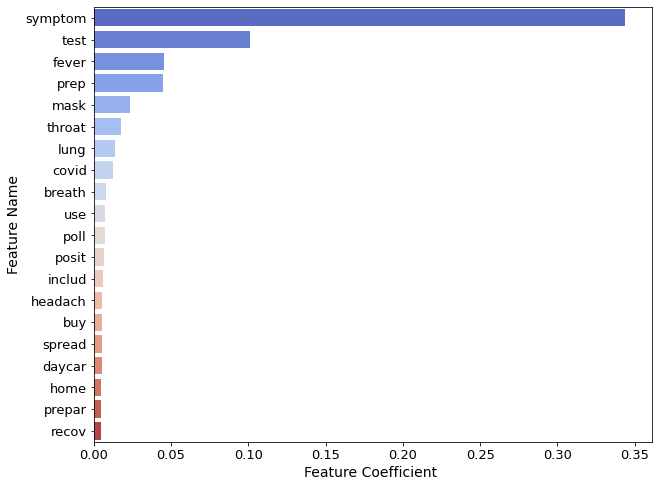

In [38]:
plt.figure( figsize=(10,8))
sns.barplot(x='Feature Coefficient',y='Feature Name', 
            data=fi.sort_values(by='Feature Coefficient', ascending=False).iloc[0:20],
            palette='coolwarm')
plt.xlabel('Feature Coefficient ',fontsize=14)
plt.ylabel('Feature Name', fontsize = 14)
plt.tick_params('both', labelsize = 13)

# Evaluate Model

Score on training set: 0.9979729729729729
Score on testing set: 0.8514328808446455
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       586
           1       0.86      0.88      0.87       740

    accuracy                           0.85      1326
   macro avg       0.85      0.85      0.85      1326
weighted avg       0.85      0.85      0.85      1326



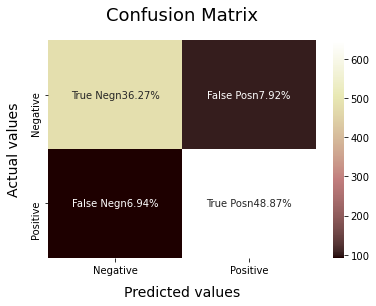

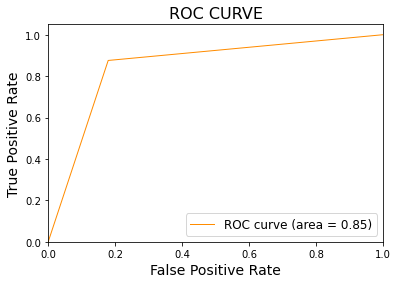

In [39]:
# View confusion matrix
model_Evaluate(dt, Xcv_train, Xcv_test, y_train, y_test)

In [40]:
save_model_Evaluate_values(gs, Xcv_train, Xcv_test, y_train, y_test,  
                             model_name='Decision Tree/GridSearchCV', 
                             balanced = is_balanced)

(   score   metric                       model balanced
 0   0.88  R_train  Decision Tree/GridSearchCV      yes
 1   0.84   R_test  Decision Tree/GridSearchCV      yes,
    is_pandemicPreps  is_covid19positive     metric  \
 0              0.75                0.95  precision   
 1              0.95                0.75     recall   
 2              0.84                0.84     fscore   
 3            586.00              740.00    support   
 
                         model balanced  
 0  Decision Tree/GridSearchCV      yes  
 1  Decision Tree/GridSearchCV      yes  
 2  Decision Tree/GridSearchCV      yes  
 3  Decision Tree/GridSearchCV      yes  ,
    score     metric                       model balanced
 0   0.42   True Neg  Decision Tree/GridSearchCV      yes
 1   0.02  False Pos  Decision Tree/GridSearchCV      yes
 2   0.14  False Neg  Decision Tree/GridSearchCV      yes
 3   0.42   True Pos  Decision Tree/GridSearchCV      yes)

In [64]:
# score = pd.concat([score1[0], score2[0]], ignore_index=True)
# score = pd.concat([score1[1], score2[1]], ignore_index=True)
# score = pd.concat([score1[2], score2[2]], ignore_index=True)


## Visualizing the Output of Decision Trees


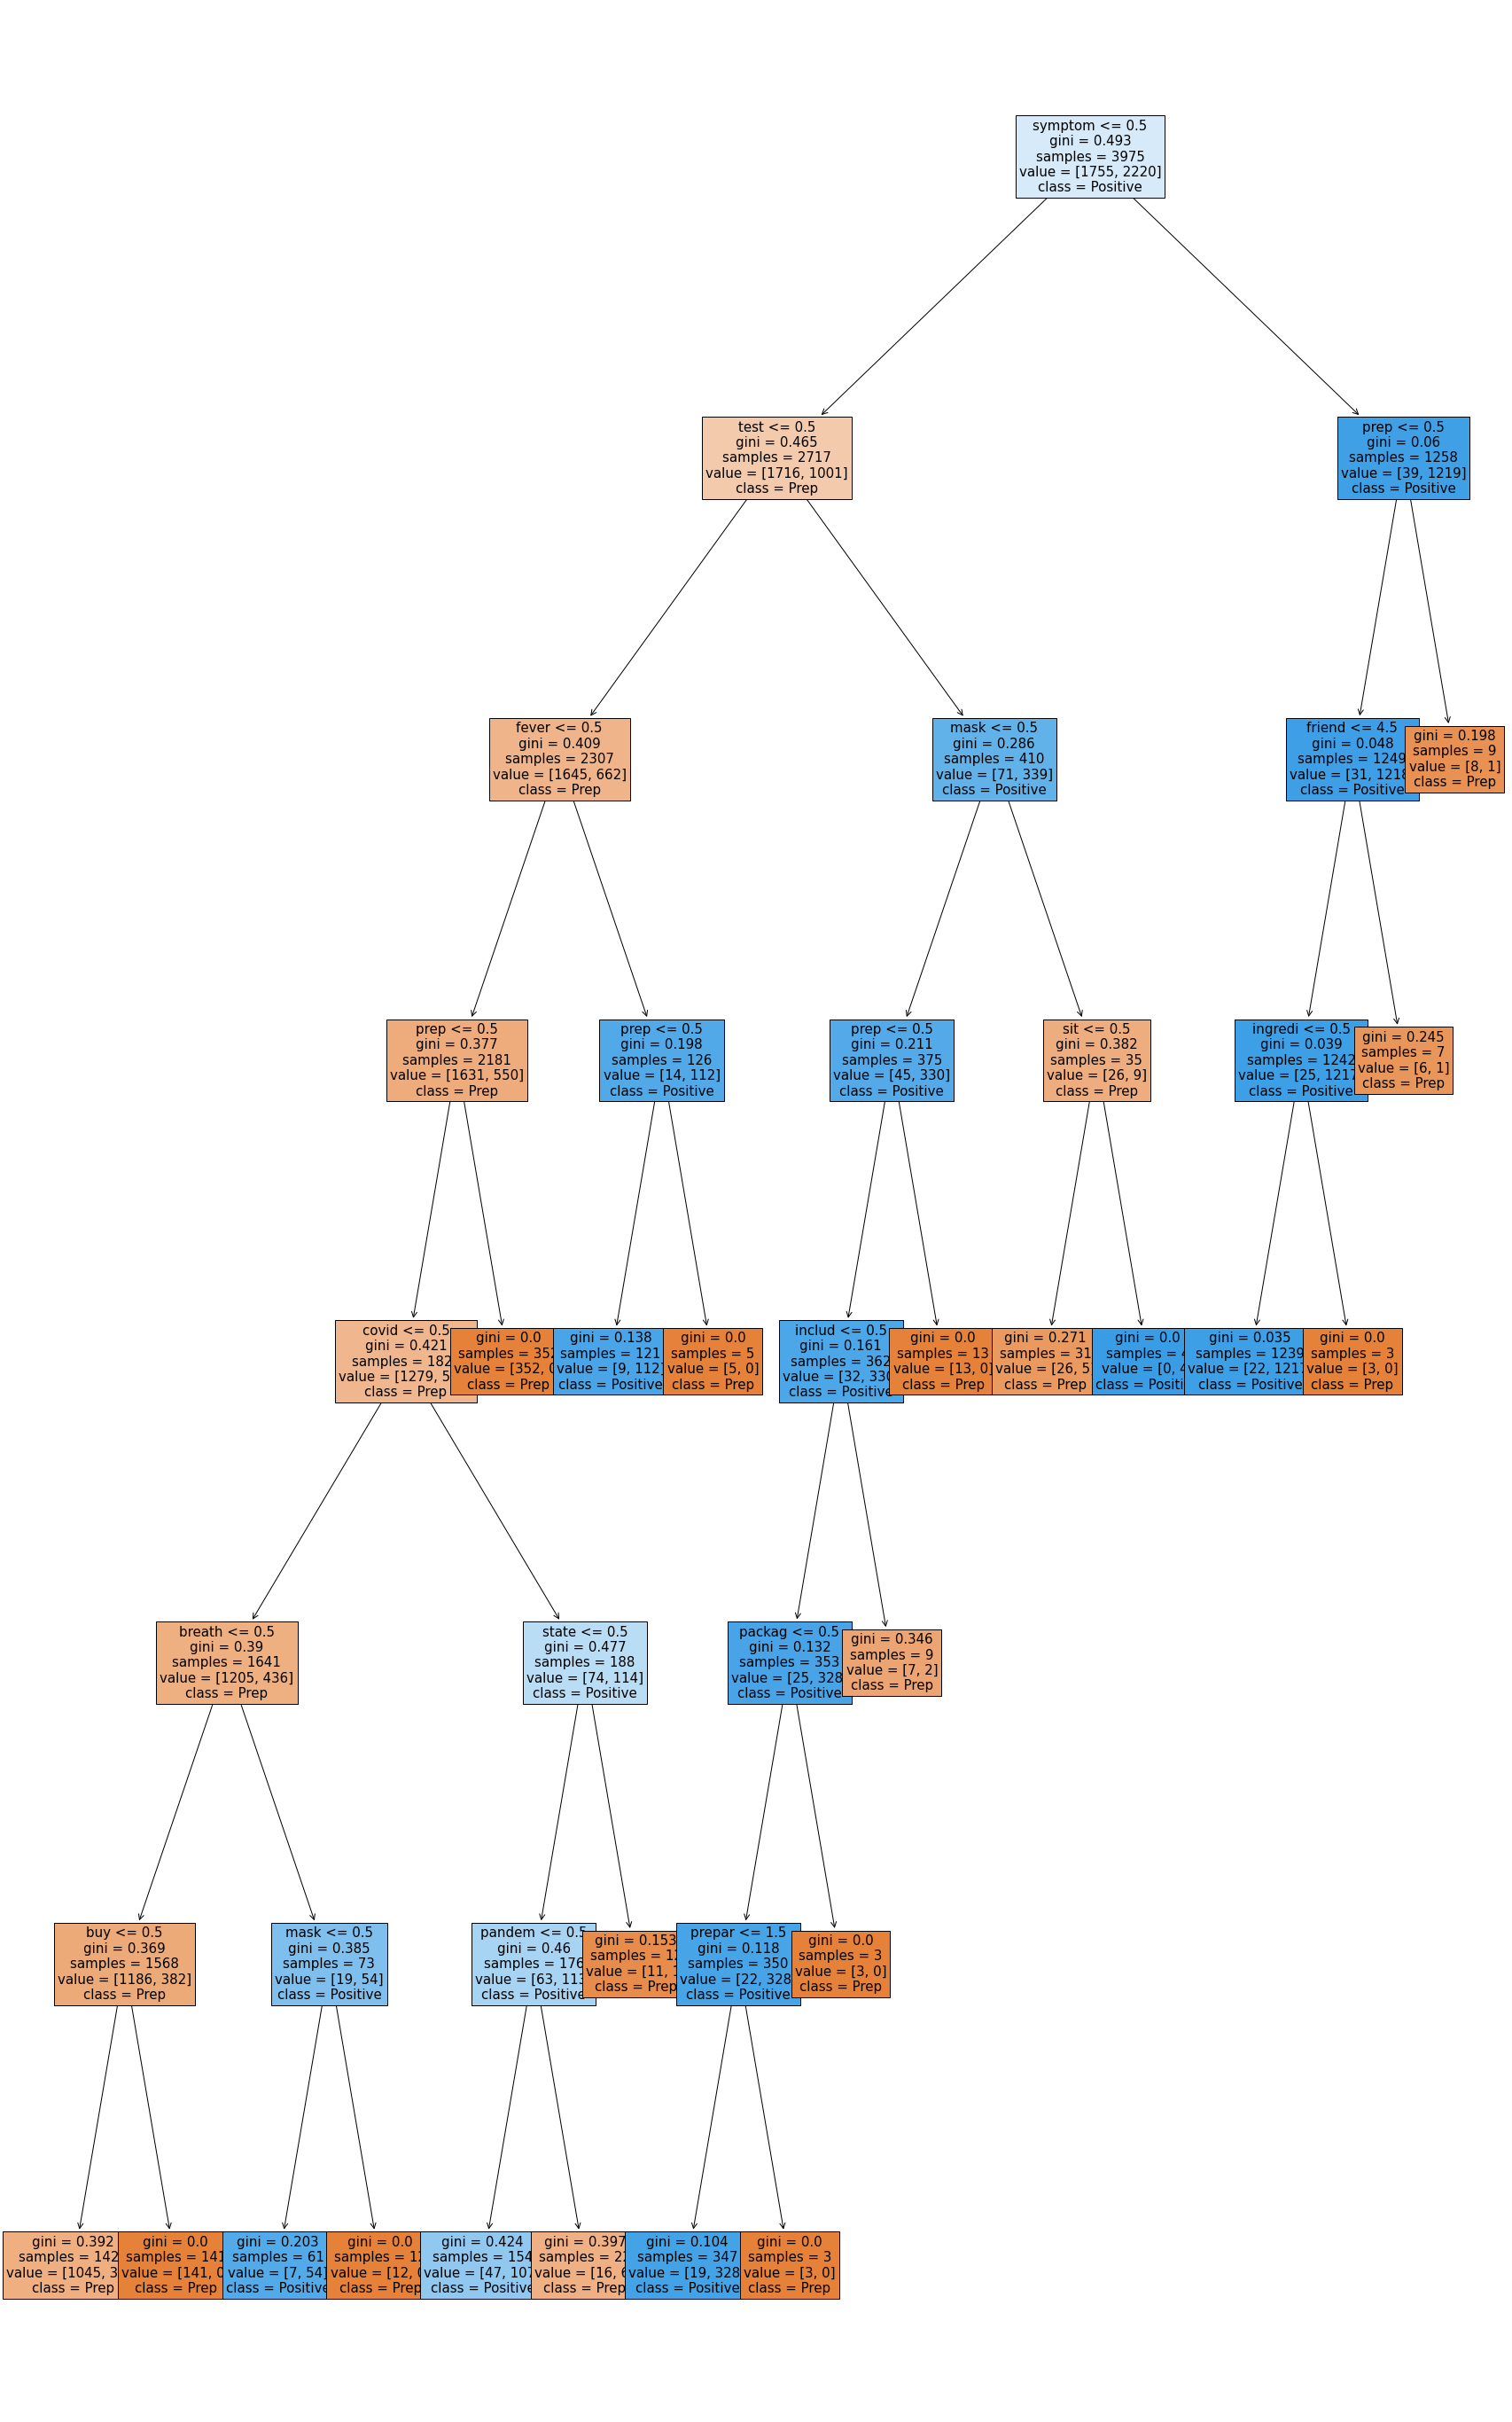

In [24]:
# Import plot_tree from sklearn.tree module.
from sklearn.tree import plot_tree

# Establish size of figure.
plt.figure(figsize = (30, 50))

# Plot our tree.
plot_tree(gs.best_estimator_,
          feature_names = df_X_train.columns,
          class_names = ['Prep', 'Positive'],
          filled = True,
          fontsize=15);

In [66]:
score = [pd.concat([score1[i], score2[i]], ignore_index=True) for i in range(3)]

def attach_df_report(score):
    # accuracy - 1
    df1 = pd.read_csv('../datasets/models_metrics_report_accuracy.csv', index_col=0)
    df2 = score[1]
    pd.concat([df1,df2],ignore_index=True).to_csv('../datasets/models_metrics_report_accuracy.csv')
    # accuracy - 0
    df1 = pd.read_csv('../datasets/models_metrics_report_precision_recall.csv', index_col=0)
    df2 = score[0]
    pd.concat([df1,df2],ignore_index=True).to_csv('../datasets/models_metrics_report_precision_recall.csv')
    # accuracy - 2
    df1 = pd.read_csv('../datasets/models_metrics_report_confusionMatrix.csv', index_col=0)
    df2 = score[2]
    pd.concat([df1,df2],ignore_index=True).to_csv('../datasets/models_metrics_report_confusionMatrix.csv')
    
attach_df_report(score)    
